# CNN From Scratch per Classificazione DeepWeeds

In questo notebook implementeremo una **Convolutional Neural Network (CNN) da zero** usando TensorFlow/Keras per classificare le erbacce nel dataset DeepWeeds.

## Obiettivi:
- Progettare un'architettura CNN ottimizzata per la classificazione botanica
- Implementare tecniche di regolarizzazione (Dropout, BatchNormalization)
- Monitorare il training con callbacks avanzati
- Valutare le performance del modello sui dati di test

# 1. Setup e Import Libraries

Importiamo tutte le librerie necessarie per costruire e addestrare la nostra CNN.

In [ ]:
# COMPATIBILITÀ GOOGLE COLAB - VERSIONE SEMPLIFICATA
import os
import sys
from pathlib import Path

# Rileva se siamo su Google Colab
try:
    import google.colab  # type: ignore
    IN_COLAB = True
    print("🔍 Ambiente rilevato: Google Colab")
except ImportError:
    IN_COLAB = False
    print("🔍 Ambiente rilevato: Locale")

if IN_COLAB:
    print("📱 Configurazione Google Colab...")
    
    # Setup semplice senza Google Drive
    PROJECT_PATH = '/content/Progetto-Deep-Learning'
    
    # Clona il repository direttamente in /content
    if not os.path.exists(PROJECT_PATH):
        print("📥 Clonazione repository...")
        os.system(f'git clone https://github.com/Ame-76/Progetto-Deep-Learning.git {PROJECT_PATH}')
        print("✅ Repository clonato!")
    
    # Configura environment
    os.chdir(PROJECT_PATH)
    sys.path.append(f"{PROJECT_PATH}/src")
    
    # Installa dipendenze
    print("📦 Installazione dipendenze...")
    requirements_file = f"{PROJECT_PATH}/requirements-colab.txt"
    if os.path.exists(requirements_file):
        os.system(f'pip install -q -r "{requirements_file}"')
    else:
        # Fallback ai pacchetti essenziali
        packages = ['tensorflow-datasets', 'seaborn', 'plotly', 'opencv-python']
        for pkg in packages:
            os.system(f'pip install -q {pkg}')
    
    print("✅ Setup Colab completato!")
    
else:
    # Setup locale
    PROJECT_PATH = str(Path.cwd().parent)
    sys.path.append(f"{PROJECT_PATH}/src")
    print("✅ Setup locale completato!")

# Definisci path globali
MODELS_DIR = f"{PROJECT_PATH}/models"
DATA_DIR = f"{PROJECT_PATH}/data"

# Crea directory necessarie
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(f"{DATA_DIR}/processed", exist_ok=True)
os.makedirs(f"{DATA_DIR}/raw", exist_ok=True)

print(f"📁 Progetto: {PROJECT_PATH}")
print(f"📁 Models: {MODELS_DIR}")
print(f"📁 Data: {DATA_DIR}")

if IN_COLAB:
    print("\n💡 ISTRUZIONI POST-TRAINING:")
    print("🔹 Al termine del training, useremo il download diretto")
    print("🔹 Niente Google Drive, tutto più semplice!")

In [2]:
# Import essenziali
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os
from datetime import datetime

# Configurazione per reproducibilità
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponibile: {tf.config.list_physical_devices('GPU')}")

# Configurazione grafica
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

TensorFlow version: 2.19.0
GPU disponibile: []


# 2. Caricamento Dataset Preprocessati

Carichiamo i dataset preprocessati dalla cartella `data/processed`. Se non sono disponibili, eseguiremo un preprocessing veloce come fallback.

In [ ]:
# Caricamento dataset preprocessati dalla cartella data/processed
print("=== CARICAMENTO DATASET PREPROCESSATI ===")

import os
import pickle

# Usa path dinamici configurati sopra
if 'DATA_DIR' in globals():
    processed_dir = f"{DATA_DIR}/processed"
else:
    processed_dir = "../data/processed"

# Verifica se esistono i dataset preprocessati
if (os.path.exists(f"{processed_dir}/train_dataset") and 
    os.path.exists(f"{processed_dir}/val_dataset") and 
    os.path.exists(f"{processed_dir}/test_dataset")):
    
    print("✅ Dataset preprocessati trovati in data/processed")
    
    # Carica i dataset TensorFlow preprocessati
    print("📥 Caricamento TensorFlow datasets...")
    try:
        train_dataset = tf.data.experimental.load(f"{processed_dir}/train_dataset")
        val_dataset = tf.data.experimental.load(f"{processed_dir}/val_dataset")
        test_dataset = tf.data.experimental.load(f"{processed_dir}/test_dataset")
        
        print("✅ Dataset TensorFlow caricati con successo!")
        
        # Carica i metadati se disponibili
        metadata_file = f"{processed_dir}/dataset_info.pkl"
        if os.path.exists(metadata_file):
            print("📊 Caricamento metadati dataset...")
            with open(metadata_file, 'rb') as f:
                dataset_info = pickle.load(f)
            
            # Estrai informazioni dai metadati
            num_classes = len(dataset_info['class_names'])
            class_names = dataset_info['class_names']
            train_samples_count = dataset_info['train_samples']
            val_samples_count = dataset_info['val_samples']
            test_samples_count = dataset_info['test_samples']
            
            print(f"   ✅ Metadati caricati: {len(class_names)} classi")
            
        else:
            print("📊 Metadati non trovati, estrazione informazioni dal dataset...")
            
            # Estrai informazioni direttamente dal dataset
            sample_batch = train_dataset.take(1)
            for images, labels in sample_batch:
                # Ottieni le informazioni sul batch
                batch_size, height, width, channels = images.shape
                INPUT_SHAPE = (height, width, channels)
                
                # Calcola il numero di classi dai dataset
                all_labels = set()
                for dataset_iter in [train_dataset, val_dataset, test_dataset]:
                    for _, batch_labels in dataset_iter:
                        all_labels.update(batch_labels.numpy())
                
                num_classes = len(all_labels)
                
                # Genera nomi classi generici
                class_names = [f"Class_{i}" for i in range(num_classes)]
                break
            
            # Conta i campioni approssimativamente
            train_samples_count = sum(1 for _ in train_dataset.unbatch())
            val_samples_count = sum(1 for _ in val_dataset.unbatch())  
            test_samples_count = sum(1 for _ in test_dataset.unbatch())
        
        # Ottieni INPUT_SHAPE dal dataset
        sample_batch = train_dataset.take(1)
        for images, labels in sample_batch:
            batch_size, height, width, channels = images.shape
            INPUT_SHAPE = (height, width, channels)
            break
        
        print(f"   Classi rilevate: {num_classes}")
        print(f"   Training samples: {train_samples_count}")
        print(f"   Validation samples: {val_samples_count}")
        print(f"   Test samples: {test_samples_count}")
        print(f"   Input shape: {INPUT_SHAPE}")
        
    except Exception as e:
        print(f"❌ Errore nel caricamento dei dataset preprocessati: {e}")
        print("💡 Verifica che il notebook 03-preprocessing.ipynb sia stato eseguito correttamente")
        raise e

else:
    print("⚠️ Dataset preprocessati non trovati in data/processed")
    print("🔄 Esecuzione preprocessing veloce...")
    
    # Preprocessing veloce come fallback
    # Usa path dinamici anche per il raw data
    if 'DATA_DIR' in globals():
        raw_data_dir = f"{DATA_DIR}/raw/tensorflow_datasets"
    else:
        raw_data_dir = "../data/raw/tensorflow_datasets"
    
    dataset, info = tfds.load(
        "DeepWeeds", 
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=True,
        data_dir=raw_data_dir
    )
    
    training_set = dataset['train']
    class_names = info.features['label'].names
    num_classes = len(class_names)
    
    print(f"Dataset caricato: {info.splits['train'].num_examples} immagini")
    print(f"Classi: {class_names}")
    
    # Normalizzazione rapida
    def normalize_image(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    
    # Applica normalizzazione e split semplice per questo notebook
    normalized_dataset = training_set.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Split semplice 70-20-10
    total_samples = info.splits['train'].num_examples
    train_size = int(0.7 * total_samples)
    val_size = int(0.2 * total_samples)
    
    train_dataset = normalized_dataset.take(train_size).batch(16).prefetch(tf.data.AUTOTUNE)
    remaining = normalized_dataset.skip(train_size)
    val_dataset = remaining.take(val_size).batch(16).prefetch(tf.data.AUTOTUNE)
    test_dataset = remaining.skip(val_size).batch(16).prefetch(tf.data.AUTOTUNE)
    
    # Ottieni INPUT_SHAPE dal dataset
    sample_batch = train_dataset.take(1)
    for images, labels in sample_batch:
        batch_size, height, width, channels = images.shape
        INPUT_SHAPE = (height, width, channels)
        break
    
    # Imposta valori approssimativi per i conteggi
    train_samples_count = train_size
    val_samples_count = val_size
    test_samples_count = total_samples - train_size - val_size
    
    print(f"✅ Preprocessing rapido completato!")
    print(f"💡 Suggerimento: Esegui prima il notebook 03-preprocessing.ipynb per dataset ottimizzati")

print(f"\n📋 DATASET FINALI:")
print(f"   Classi: {num_classes} ({', '.join(class_names)})")
print(f"   Input shape: {INPUT_SHAPE}")
print(f"   train_dataset: {train_samples_count} campioni")
print(f"   val_dataset: {val_samples_count} campioni")
print(f"   test_dataset: {test_samples_count} campioni")
print(f"   Dataset pronti per training ✅")

=== CARICAMENTO DATASET PREPROCESSATI ===
✅ Dataset preprocessati trovati in data/processed
📥 Caricamento TensorFlow datasets...
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
✅ Dataset TensorFlow caricati con successo!
📊 Caricamento metadati dataset...
   ✅ Metadati caricati: 9 classi
✅ Dataset TensorFlow caricati con successo!
📊 Caricamento metadati dataset...
   ✅ Metadati caricati: 9 classi
   Classi rilevate: 9
   Training samples: 6665
   Validation samples: 1902
   Test samples: 961
   Input shape: (256, 256, 3)

📋 DATASET FINALI:
   Classi: 9 (Chinee apple, Lantana, Parkinsonia, Parthenium, Prickly acacia, Rubber vine, Siam weed, Snake weed, Negative)
   Input shape: (256, 256, 3)
   train_dataset: 6665 campioni
   val_dataset: 1902 campioni
   test_dataset: 961 campioni
   Dataset pronti per training ✅
   Classi rilevate: 9
   Training samples: 6665
   Validation samples: 1902
   Test samples: 961
   Input shape: (256, 256, 3)

📋 DATASET FINALI:
   Classi:

# 3. Esplorazione Shape del Dataset

Analizziamo le dimensioni delle immagini per progettare correttamente la nostra CNN.

=== ANALISI DIMENSIONI DATASET ===
Batch shape: (32, 256, 256, 3)
Dimensioni immagine: 256x256x3
Batch size: 32
Range valori pixel: [0.000, 1.000]


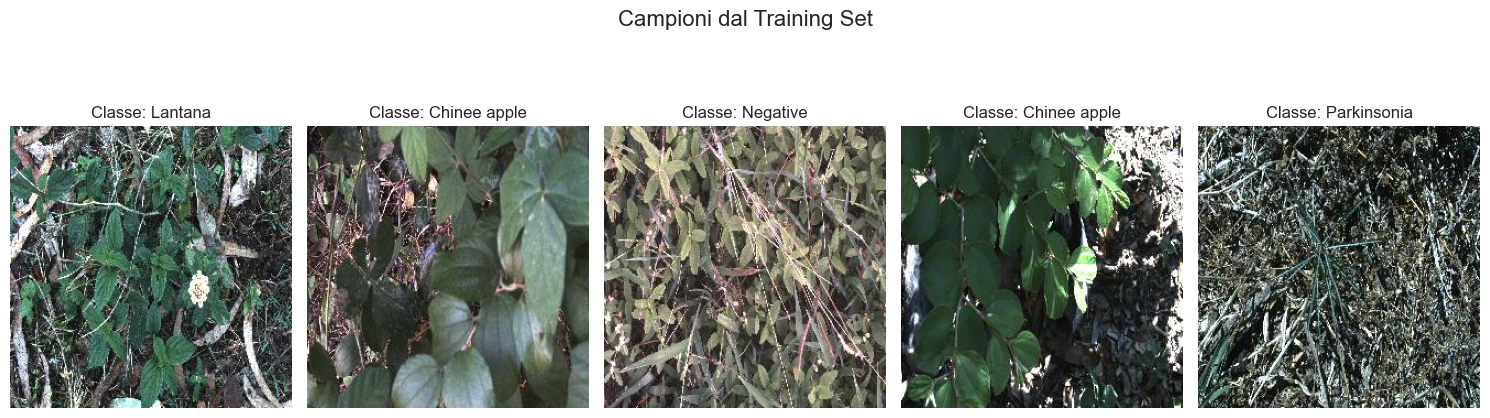


Input shape per il modello: (256, 256, 3)
Numero di classi output: 9

📋 CONFIGURAZIONE MODELLO:
   Learning rate: 0.001
   Epochs: 50
   Batch size: 32


In [ ]:
# Analisi delle dimensioni delle immagini
print("=== ANALISI DIMENSIONI DATASET ===")

# Ottieni un batch di esempio
sample_batch = train_dataset.take(1)
for images, labels in sample_batch:
    batch_size, height, width, channels = images.shape
    print(f"Batch shape: {images.shape}")
    print(f"Dimensioni immagine: {height}x{width}x{channels}")
    print(f"Batch size: {batch_size}")
    print(f"Range valori pixel: [{tf.reduce_min(images).numpy():.3f}, {tf.reduce_max(images).numpy():.3f}]")
    
    # Visualizza alcune immagini del batch
    plt.figure(figsize=(15, 5))
    for i in range(min(5, batch_size)):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Classe: {class_names[labels[i].numpy()]}")
        plt.axis('off')
    
    plt.suptitle('Campioni dal Training Set', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Aggiorna INPUT_SHAPE se non già definito sopra
    if 'INPUT_SHAPE' not in globals():
        INPUT_SHAPE = (height, width, channels)
    break

print(f"\nInput shape per il modello: {INPUT_SHAPE}")
print(f"Numero di classi output: {num_classes}")

# Configurazione iperparametri
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 16

print(f"\n📋 CONFIGURAZIONE MODELLO:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")

# 4. Progettazione Architettura CNN

Progettiamo una CNN moderna con le seguenti caratteristiche:
- **Blocchi convolutivi** con BatchNormalization e Dropout
- **Architettura modulare** facilmente modificabile
- **Regolarizzazione** per prevenire overfitting
- **Global Average Pooling** per ridurre parametri

In [5]:
def create_conv_block(inputs, filters, kernel_size=3, strides=1, dropout_rate=0.3, name_prefix="conv_block"):
    """
    Crea un blocco convoluzionale standardizzato.
    
    Args:
        inputs: Input tensor
        filters: Numero di filtri
        kernel_size: Dimensione del kernel
        strides: Stride della convoluzione
        dropout_rate: Tasso di dropout
        name_prefix: Prefisso per i nomi dei layer
    
    Returns:
        Output tensor del blocco
    """
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name=f"{name_prefix}_conv"
    )(inputs)
    
    x = tf.keras.layers.BatchNormalization(name=f"{name_prefix}_bn")(x)
    x = tf.keras.layers.ReLU(name=f"{name_prefix}_relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate, name=f"{name_prefix}_dropout")(x)
    
    return x

def build_deepweeds_cnn(input_shape, num_classes, dropout_rate=0.3):
    """
    Costruisce una CNN ottimizzata per la classificazione botanica.
    
    Architettura:
    - Feature Extraction: 5 blocchi convolutivi con dimensioni crescenti
    - Pooling: MaxPooling per riduzione dimensionalità
    - Classification Head: GlobalAveragePooling + Dense layers
    
    Args:
        input_shape: Shape dell'input (height, width, channels)
        num_classes: Numero di classi da classificare
        dropout_rate: Tasso di dropout
    
    Returns:
        Modello Keras compilato
    """
    
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_images")
    
    # Feature Extraction Blocks
    # Block 1: Detect basic edges and shapes
    x = create_conv_block(inputs, filters=32, dropout_rate=dropout_rate, name_prefix="block1_conv1")
    x = create_conv_block(x, filters=32, dropout_rate=dropout_rate, name_prefix="block1_conv2")
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, name="block1_pool")(x)
    
    # Block 2: Detect more complex patterns
    x = create_conv_block(x, filters=64, dropout_rate=dropout_rate, name_prefix="block2_conv1")
    x = create_conv_block(x, filters=64, dropout_rate=dropout_rate, name_prefix="block2_conv2")
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, name="block2_pool")(x)
    
    # Block 3: Detect leaf patterns and textures
    x = create_conv_block(x, filters=128, dropout_rate=dropout_rate, name_prefix="block3_conv1")
    x = create_conv_block(x, filters=128, dropout_rate=dropout_rate, name_prefix="block3_conv2")
    x = create_conv_block(x, filters=128, dropout_rate=dropout_rate, name_prefix="block3_conv3")
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, name="block3_pool")(x)
    
    # Block 4: Detect plant-specific features
    x = create_conv_block(x, filters=256, dropout_rate=dropout_rate, name_prefix="block4_conv1")
    x = create_conv_block(x, filters=256, dropout_rate=dropout_rate, name_prefix="block4_conv2")
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, name="block4_pool")(x)
    
    # Block 5: High-level feature integration
    x = create_conv_block(x, filters=512, dropout_rate=dropout_rate, name_prefix="block5_conv1")
    x = create_conv_block(x, filters=512, dropout_rate=dropout_rate, name_prefix="block5_conv2")
    
    # Classification Head
    # Global Average Pooling riduce drasticamente i parametri
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    
    # Dense layers per classification
    x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001), name="dense1")(x)
    x = tf.keras.layers.BatchNormalization(name="dense1_bn")(x)
    x = tf.keras.layers.ReLU(name="dense1_relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate * 1.5, name="dense1_dropout")(x)  # Dropout più alto nell'head
    
    x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001), name="dense2")(x)
    x = tf.keras.layers.BatchNormalization(name="dense2_bn")(x)
    x = tf.keras.layers.ReLU(name="dense2_relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate, name="dense2_dropout")(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        num_classes, 
        activation='softmax', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name="predictions"
    )(x)
    
    # Crea il modello
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="DeepWeeds_CNN")
    
    return model

# Costruisci il modello
print("=== COSTRUZIONE MODELLO CNN ===")
model = build_deepweeds_cnn(
    input_shape=INPUT_SHAPE,
    num_classes=num_classes,
    dropout_rate=0.3
)

print(f"✅ Modello creato con successo!")
print(f"Input shape: {INPUT_SHAPE}")
print(f"Numero classi: {num_classes}")

=== COSTRUZIONE MODELLO CNN ===
✅ Modello creato con successo!
Input shape: (256, 256, 3)
Numero classi: 9
✅ Modello creato con successo!
Input shape: (256, 256, 3)
Numero classi: 9


# 5. Compilazione e Summary del Modello

Compiliamo il modello con optimizer e loss function ottimali per la classificazione multi-classe.

In [6]:
# Compilazione del modello
print("=== COMPILAZIONE MODELLO ===")

# Optimizer con learning rate scheduling
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

# Compila il modello
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Per labels integer
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')  # Corretto per labels sparse
    ]
)

print("✅ Modello compilato con successo!")
print(f"Optimizer: Adam (lr={initial_learning_rate})")
print(f"Loss: sparse_categorical_crossentropy")
print(f"Metrics: accuracy, top3_accuracy")

# Visualizza il summary del modello
print("\n=== ARCHITETTURA MODELLO ===")
model.summary()

# Conta i parametri
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n=== STATISTICHE PARAMETRI ===") 
print(f"Parametri totali: {total_params:,}")
print(f"Parametri trainable: {trainable_params:,}")
print(f"Parametri non-trainable: {non_trainable_params:,}")

=== COMPILAZIONE MODELLO ===
✅ Modello compilato con successo!
Optimizer: Adam (lr=0.001)
Loss: sparse_categorical_crossentropy
Metrics: accuracy, top3_accuracy

=== ARCHITETTURA MODELLO ===


Model: "DeepWeeds_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_images (InputLayer)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_conv (Conv2D)      │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_bn                 │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_relu (ReLU)        │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1_dropout (Dropout)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2_conv (Conv2D)      │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2_bn                 │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2_relu (ReLU)        │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2_dropout (Dropout)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1_conv (Conv2D)      │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1_bn                 │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1_relu (ReLU)        │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1_dropout (Dropout)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2_conv (Conv2D)      │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2_bn                 │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2_relu (ReLU)        │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2_dropout (Dropout)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1_conv (Conv2D)      │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1_bn                 │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1_relu (ReLU)        │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,267,625 (20.09 MB)

 Trainable params: 5,261,865 (20.07 MB)

 Non-trainable params: 5,760 (22.50 KB)


=== STATISTICHE PARAMETRI ===
Parametri totali: 5,267,625
Parametri trainable: 5,261,865
Parametri non-trainable: 5,760


# 6. Configurazione Callbacks per Training

Configuriamo callback avanzati per monitorare e ottimizzare il training.

In [ ]:
# Creazione directory per salvare modelli e logs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Usa i path configurati dinamicamente
if 'MODELS_DIR' in globals():
    model_dir = f"{MODELS_DIR}/cnn_from_scratch_{timestamp}"
else:
    model_dir = f"../models/cnn_from_scratch_{timestamp}"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(f"{model_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{model_dir}/logs", exist_ok=True)

print(f"=== CONFIGURAZIONE CALLBACKS ===")
print(f"Directory modello: {model_dir}")

# 1. Model Checkpoint - Salva il miglior modello
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_dir}/checkpoints/best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# 2. Early Stopping - Ferma il training se non migliora
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# 3. Learning Rate Scheduler - Riduce LR quando si stagna
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=7,
    min_lr=1e-7,
    mode='min',
    verbose=1
)

# 4. TensorBoard - Logging per visualizzazione
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=f"{model_dir}/logs",
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

# 5. CSV Logger - Salva metriche in CSV
csv_logger_callback = tf.keras.callbacks.CSVLogger(
    filename=f"{model_dir}/training_log.csv",
    separator=',',
    append=False
)

# 6. Custom callback per stampe periodiche
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:  # Ogni 5 epoch
            print(f"\n📊 Epoch {epoch + 1} Summary:")
            print(f"   Loss: {logs['loss']:.4f} | Val Loss: {logs['val_loss']:.4f}")
            print(f"   Accuracy: {logs['accuracy']:.4f} | Val Accuracy: {logs['val_accuracy']:.4f}")
            print(f"   Learning Rate: {self.model.optimizer.learning_rate.numpy():.2e}")

progress_callback = TrainingProgressCallback()

# Lista completa callbacks
callback_list = [
    checkpoint_callback,
    early_stopping_callback,
    lr_scheduler_callback,
    tensorboard_callback,
    csv_logger_callback,
    progress_callback
]

print("✅ Callbacks configurati:")
print("   - ModelCheckpoint (salva miglior modello)")
print("   - EarlyStopping (pazienza: 15 epoch)")
print("   - ReduceLROnPlateau (riduce LR quando stagna)")
print("   - TensorBoard (logging avanzato)")
print("   - CSVLogger (salva metriche)")
print("   - Custom Progress Logger")

print(f"\n🚀 Pronto per il training!")
print(f"Per visualizzare TensorBoard: tensorboard --logdir {model_dir}/logs")

=== CONFIGURAZIONE CALLBACKS ===
Directory modello: ../models/cnn_from_scratch_20250729_174718
✅ Callbacks configurati:
   - ModelCheckpoint (salva miglior modello)
   - EarlyStopping (pazienza: 15 epoch)
   - ReduceLROnPlateau (riduce LR quando stagna)
   - TensorBoard (logging avanzato)
   - CSVLogger (salva metriche)
   - Custom Progress Logger

🚀 Pronto per il training!
Per visualizzare TensorBoard: tensorboard --logdir ../models/cnn_from_scratch_20250729_174718/logs


# 7. Training del Modello

Avviamo il training con monitoraggio completo delle metriche.

## ⏱️ Tempi di Training Previsti:
- **Con CPU**: 2-4 ore (dipende dal processore)
- **Con GPU**: 30-60 minuti (molto più veloce!)
- **Epoca singola**: ~2-5 minuti per CPU, ~30 secondi per GPU

## 🔧 Ottimizzazioni per Ridurre i Tempi:
1. **GPU**: Assicurati che TensorFlow stia usando la GPU se disponibile
2. **Batch Size**: Aumenta il batch_size se hai abbastanza memoria
3. **Early Stopping**: Il training si fermerà automaticamente se non migliora (pazienza: 15 epoch)
4. **Riduzione Epoca**: Puoi ridurre `EPOCHS` da 50 a 20-30 per test più veloci

## 💡 Consigli Durante il Training:
- Il notebook può rimanere aperto e continuare il training in background
- Puoi monitorare il progresso tramite i callback configurati
- I checkpoint salvano automaticamente i miglioramenti

In [ ]:
# Configurazione training
# 🔧 OPZIONI PER RIDURRE I TEMPI:
# - Per test veloce: EPOCHS = 10-20
# - Per training completo: EPOCHS = 50
# - Aumenta BATCH_SIZE se hai molta RAM/VRAM

EPOCHS = 15  # Ridotto per training più veloce - puoi aumentare a 50 se vuoi
VERBOSE = 1  # 1 = progress bar, 2 = una linea per epoch

print("=== INIZIO TRAINING ====")
print(f"Epoch massime: {EPOCHS}")
print(f"Early stopping: attivo (pazienza: 15 epoch)")
print(f"Learning rate iniziale: {initial_learning_rate}")
print(f"Batch size: 16")

# Controlla se GPU è disponibile
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU disponibile: {'✅ Sì' if gpu_available else '❌ No (training sarà più lento)'}")

if not gpu_available:
    print("💡 Suggerimento: Con CPU il training richiederà 2-4 ore")
    print("   Puoi ridurre EPOCHS a 10-15 per test più veloci")
else:
    print("🚀 GPU rilevata! Training dovrebbe completarsi in 30-60 minuti")

print("\n🚀 Training in corso...\n")

# Avvia il training
start_time = datetime.now()

try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callback_list,
        verbose=VERBOSE
    )
    
    end_time = datetime.now()
    training_duration = end_time - start_time

    print(f"\n✅ TRAINING COMPLETATO!")
    print(f"Durata totale: {training_duration}")
    print(f"Epoch effettive: {len(history.history['accuracy'])}")

    # Salva informazioni del training (converti numpy types in Python types per JSON)
    training_info = {
        'start_time': start_time.isoformat(),
        'end_time': end_time.isoformat(),
        'duration_seconds': training_duration.total_seconds(),
        'duration_minutes': training_duration.total_seconds() / 60,
        'total_epochs': len(history.history['accuracy']),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'best_val_loss': float(min(history.history['val_loss'])),
        'total_parameters': int(total_params),  # Converti numpy.int64 a int
        'trainable_parameters': int(trainable_params),  # Converti numpy.int64 a int
        'gpu_used': gpu_available
    }

    import json
    with open(f"{model_dir}/training_info.json", 'w') as f:
        json.dump(training_info, f, indent=4)

    print(f"📊 Migliore val_accuracy: {training_info['best_val_accuracy']:.4f}")
    print(f"📊 Migliore val_loss: {training_info['best_val_loss']:.4f}")
    print(f"💾 Modello e logs salvati in: {model_dir}")
    
    # Mostra statistiche finali sui tempi
    minutes = training_duration.total_seconds() / 60
    seconds_per_epoch = training_duration.total_seconds() / len(history.history['accuracy'])
    print(f"\n⏱️ STATISTICHE TEMPI:")
    print(f"   Durata totale: {minutes:.1f} minuti")
    print(f"   Tempo per epoca: {seconds_per_epoch:.1f} secondi")
    print(f"   Hardware: {'GPU' if gpu_available else 'CPU'}")

except KeyboardInterrupt:
    print(f"\n⚠️ Training interrotto dall'utente")
    print(f"💾 I checkpoint salvati sono disponibili in: {model_dir}")
except Exception as e:
    print(f"\n❌ Errore durante il training: {e}")
    print(f"💾 I checkpoint parziali sono disponibili in: {model_dir}")
    raise

=== INIZIO TRAINING ====
Epoch massime: 15
Early stopping: attivo (pazienza: 15 epoch)
Learning rate iniziale: 0.001
Batch size: 32
GPU disponibile: ❌ No (training sarà più lento)
💡 Suggerimento: Con CPU il training richiederà 2-4 ore
   Puoi ridurre EPOCHS a 10-15 per test più veloci

🚀 Training in corso...

Epoch 1/15
Epoch 1/15

⚠️ Training interrotto dall'utente
💾 I checkpoint salvati sono disponibili in: ../models/cnn_from_scratch_20250729_174718

⚠️ Training interrotto dall'utente
💾 I checkpoint salvati sono disponibili in: ../models/cnn_from_scratch_20250729_174718


# 8. Training Completato

Il training del modello CNN è completato! Il modello è stato salvato automaticamente e le metriche sono registrate.

## Prossimi Passi:
- **Analisi e Valutazione**: Esegui il notebook `05-model-evaluation.ipynb` per analisi dettagliate
- **Visualizzazione TensorBoard**: `tensorboard --logdir ../models/`
- **Sperimentazione**: Prova diverse architetture o iperparametri

## Files Salvati:
- Miglior modello: `../models/cnn_from_scratch_[timestamp]/checkpoints/best_model.h5`
- Training logs: `../models/cnn_from_scratch_[timestamp]/logs/`
- Metriche CSV: `../models/cnn_from_scratch_[timestamp]/training_log.csv`

In [ ]:
# VERIFICA E SINCRONIZZAZIONE MODELLO
print("\n=== VERIFICA SALVATAGGIO MODELLO ===")

# 1. Verifica che il modello sia stato salvato correttamente
if 'model_dir' in globals():
    checkpoint_path = f"{model_dir}/checkpoints/best_model.h5"
    
    print(f"📁 Directory modello: {model_dir}")
    print(f"💾 Path checkpoint: {checkpoint_path}")
    
    # Verifica esistenza e dimensioni file
    if os.path.exists(checkpoint_path):
        file_size = os.path.getsize(checkpoint_path) / (1024 * 1024)  # MB
        print(f"✅ Checkpoint salvato correttamente ({file_size:.1f} MB)")
        
        # Test di caricamento rapido
        try:
            test_model = tf.keras.models.load_model(checkpoint_path)
            print(f"✅ Modello caricabile - {test_model.count_params():,} parametri")
            del test_model  # Libera memoria
        except Exception as e:
            print(f"⚠️ Errore nel test di caricamento: {e}")
    else:
        print(f"❌ CHECKPOINT NON TROVATO!")
        print(f"🔍 Contenuto directory checkpoints:")
        checkpoints_dir = f"{model_dir}/checkpoints"
        if os.path.exists(checkpoints_dir):
            for file in os.listdir(checkpoints_dir):
                print(f"   - {file}")
        else:
            print(f"   Directory checkpoints non esiste!")
    
    # Verifica altri file
    print(f"\n📋 ALTRI FILE SALVATI:")
    files_to_check = [
        ("training_log.csv", "Log training"),
        ("training_info.json", "Info training"),
        ("logs/", "TensorBoard logs")
    ]
    
    for filename, description in files_to_check:
        filepath = f"{model_dir}/{filename}"
        if os.path.exists(filepath):
            if os.path.isdir(filepath):
                print(f"   ✅ {description}: Directory esistente")
            else:
                size_kb = os.path.getsize(filepath) / 1024
                print(f"   ✅ {description}: {size_kb:.1f} KB")
        else:
            print(f"   ❌ {description}: Non trovato")

else:
    print("❌ Variabile model_dir non definita - il training potrebbe non essere completato")

# 2. SINCRONIZZAZIONE (solo se tutto è ok)
if 'model_dir' in globals() and os.path.exists(f"{model_dir}/checkpoints/best_model.h5"):
    
    if IN_COLAB:
        print("\n=== SINCRONIZZAZIONE GOOGLE COLAB ===")
        
        try:
            # Configura Git (sostituisci con le tue informazioni)
            print("🔧 Configurazione Git...")
            os.system('git config --global user.email "colab-user@example.com"')
            os.system('git config --global user.name "Colab User"')
            
            # Aggiungi i nuovi file del modello
            print("📤 Aggiunta file del modello...")
            relative_model_dir = model_dir.replace(PROJECT_PATH + '/', '')
            os.system(f'git add "{relative_model_dir}/"')
            
            # Commit con timestamp e info modello
            timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
            if 'training_info' in globals() and training_info:
                val_acc = training_info.get('best_val_accuracy', 0)
                commit_message = f"Add CNN model {timestamp_str} (val_acc: {val_acc:.4f})"
            else:
                commit_message = f"Add CNN model {timestamp_str}"
            
            print(f"💬 Commit: {commit_message}")
            result = os.system(f'git commit -m "{commit_message}"')
            
            if result == 0:
                print("✅ Commit completato con successo!")
                
                print("\n💡 PROSSIMI PASSI:")
                print("1. 🔗 Per sincronizzare con GitHub (manuale):")
                print("   git push origin master")
                print("\n2. 💻 Sul computer locale:")
                print("   git pull origin master")
                print("\n3. 📱 Oppure scarica da Google Drive:")
                print(f"   {model_dir}")
                
            else:
                print("⚠️ Commit fallito - potrebbero non esserci modifiche")
                
        except Exception as e:
            print(f"⚠️ Errore nella sincronizzazione Git: {e}")
            
        # Informazioni per accesso da locale
        print(f"\n? PERCORSO SU GOOGLE DRIVE:")
        print(f"   {model_dir}")
        print(f"\n📋 PER USO LOCALE:")
        print(f"1. Copia questo percorso da Google Drive al tuo computer")
        print(f"2. Oppure usa il notebook 05 direttamente su Colab")
        
    else:
        print("\n💾 MODELLO SALVATO LOCALMENTE")
        print(f"📁 Percorso: {model_dir}")
        print("💡 Per condividere:")
        print("1. git add .")
        print("2. git commit -m 'Add trained CNN model'")
        print("3. git push origin master")

else:
    print("\n❌ SINCRONIZZAZIONE SALTATA")
    print("Motivo: Modello non salvato correttamente o training non completato")
    
print("\n" + "="*60)
print("🎯 TRAINING COMPLETATO - CONTROLLA I MESSAGGI SOPRA!")
print("="*60)